# [In Progress]

# Programación Entera: Heurísticas para Problemas de Redes

## Descripción

[TODO]

## Autor
  
  * Sergio García Prado - [garciparedes.me](https://garciparedes.me)
  
## Fecha

  * Mayo de 2018


## Contenidos
  
  * [Introducción](#Introducción)
  * [Problemas De Redes](#Problemas-de-Redes)
    * [Flujo de Redes con Costes Fijos](#Flujo-de-Redes-con-Costes-Fijos)
    * [Árbol Recubridor Mínimo](#Árbol-Recubridor-Mínimo)
    * [Árbol Recubridor Mínimo Capacitado](#Árbol-Recubridor-Mínimo-Capacitado)
    * [Problema de Steiner](#Problema-de-Steiner)
  * [Conclusiones](#Conclusiones)

## Introducción

TODO

In [1]:
rm(list = ls())

In [2]:
library(slam, warn.conflicts = FALSE)
library(Rglpk, warn.conflicts = FALSE)
library(purrr, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(magrittr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(ggthemes, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)
library(igraph, warn.conflicts = FALSE)

Using the GLPK callable library version 4.65


In [3]:
options(repr.matrix.max.rows = 600, repr.matrix.max.cols = 600)

#### Constantes y Funciones de Apoyo

In [4]:
dataset.root <- "./data/"
dataset.folder <- paste0(dataset.root, "network/")

In [5]:
simple.file.names <- c("gr15_1.dat", "gr15_2.dat", "gr15_3.dat", "gr15_4.dat", "gr15_4.dat" )

In [6]:
Solve <- function(...) {
    Rglpk_solve_LP(...)
}

In [7]:
ReadRaw <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]") %>%
        unlist() %>%
        as.double()
    close(con)
    return(raw)
}

In [8]:
Format1DFixedCostNetworkSolution <- function(s, p) {
    
    a$optimum

    if (length(a$solution) %% p$n == 0) {
        n <- p$n 
    } else {
        n <- p$n + 1
    }
    list(
        min.cost = s$optimum,
        quantity = matrix(a$solution[1:(n ^ 2)], ncol = n, byrow = TRUE),
        edge     = matrix(a$solution[(n ^ 2 + 1):(2 * n ^ 2)], ncol = n, byrow = TRUE),
        node     = matrix(a$solution[(2 * n ^ 2 + 1):(2 * n ^ 2 + n)], ncol = n, byrow = TRUE)
    )
}

In [9]:
ReadCoordinatedFile <- function(file.path) {
    raw <- 
        file.path %>%
        ReadRaw()
    a <- matrix(0, nrow = raw[1], ncol = 2)
    a[, 1] <- raw[1 + seq(2, to = length(raw), by = 3)]
    a[, 2] <- raw[1 + seq(3, to = length(raw), by = 3)]
    
    return(a)
} 

## Problemas de Redes

TODO

### Flujo de Redes con Costes Fijos

#### Descripción

TODO

#### Modelo

TODO

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{(i,j) \in A}\left(f_{ij} \cdot y_{ij} + c_{ij} \cdot x_{ij}\right) \\
      \text{sujeto a}  & \sum\limits_{j} x_{ij} - \sum\limits_{j} x_{ji} = b_{i}, & \forall i \in N \\
                       & x_{ij} \leq u_{ij} \cdot y_{ij},  & \forall (i,j) \in A \\
                       & x_{ij} \geq 0, & \forall (i,j) \in A \\
                       & y_{ij} \in \{0, 1\},  & \forall (i,j) \in A
    \end{array}
\end{equation}

In [10]:
Solve1DFixedCostNetworkExact <- function(p) {
    
    eq <- sum(p$b)
    if (eq != 0) {
        p$n <- p$n + 1
        p$b <- rbind(p$b, - eq)
        p$A <- rbind(p$A, (cbind(seq(1, p$n - 1), p$n, 0, 0, eq)))
        if (!is.null(p$F)) {
            p$F <- rbind(p$F, 0)
        }
    } 
    
    
    obj <- rep(0, 2 * (p$n ^ 2) + p$n)

    
    conditions <- matrix(0, nrow = p$n * 2 + nrow(p$A), ncol = 2 * (p$n ^ 2) + p$n)

    for (i in 1:p$n) {
        conditions[i, (i - 1) * p$n + p$A[which(p$A[,1] == i), 2, drop = FALSE]] <-  1
        conditions[i, p$n * (p$A[which(p$A[,2] == i), 1, drop = FALSE] - 1) + i] <- -1
        conditions[p$n + nrow(p$A) + i, p$n ^ 2 + p$n * (p$A[which(p$A[,2] == i), 1, drop = FALSE] - 1) + i] <- 1
        conditions[p$n + nrow(p$A) + i, p$n ^ 2 + p$n * (i - 1) + p$A[which(p$A[,1] == i), 2, drop = FALSE]] <- 1
        conditions[p$n + nrow(p$A) + i, 2 * p$n ^ 2 + i ] <-  - 2 * p$n
    }
    

    for (i in 1:nrow(p$A)) {
        conditions[i + p$n, (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- 1
        conditions[i + p$n, p$n ^ 2 + (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- - p$A[i, 5]        
        obj[(p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- p$A[i, 4]
        obj[p$n ^ 2  + (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- p$A[i, 3]
    }

    
    if (!is.null(p$F)) {
        obj[(2 * (p$n ^ 2) + 1):(2 * (p$n ^ 2) + p$n)] <- p$F
    }
        
    rhs <- c(p$b, rep(0, nrow(p$A) + p$n))

    dir <- rep(c("==", "<="), c(p$n, nrow(p$A) + p$n))
    types <- rep(c("C", "B"), c(p$n ^ 2 , p$n ^ 2 + p$n))

    s <- Solve(obj = obj, 
               mat = conditions, 
               dir = dir, 
               rhs = rhs,
               types = types)
    
    return(s)
}

#### Ejemplos

TODO

##### distribucion.gas

TODO(@garciparedes): Do Example.

In [11]:
distribucion.gas <- 
    list(
        n = 5,
        b = matrix(c(800, 600, 0, 0, - 1400), ncol = 1),
        A = matrix(c(2, 1,  60 * 100000, 2000,  1000,
                     1, 3,  80 * 100000, 2000,  1000,
                     2, 3, 100 * 100000, 2000,  1000,
                     2, 4, 140 * 100000, 2000,  1000,
                     3, 4,  20 * 100000, 2000,  1000,
                     3, 5,            0, 2000,  1000,
                     4, 5,            0, 2000,  1000), 
                   ncol = 5, byrow = TRUE)
    )

In [12]:
a <- Solve1DFixedCostNetworkExact(distribucion.gas)
Format1DFixedCostNetworkSolution(a, distribucion.gas)

0,0,800,0,0
0,0,600,0,0
0,0,0,400,1000
0,0,0,0,400
0,0,0,0,0
0,0,1,0,0
0,0,1,0,0
0,0,0,1,1
0,0,0,0,1
0,0,0,0,0
1,1,1,1,1


##### aguas.residuales

TODO(@garciparedes): Do Example.

In [13]:
aguas.residuales <- 
    list(
        n = 9,
        b = matrix(c(27, 3, 14, 36, 21, 8, 13, 0, -122), ncol = 1),
        A = matrix(c(1, 2,  240, 21, 122,
                     1, 3,  350, 30, 122,
                     2, 3,  200, 22, 122,
                     2, 4,  750, 58, 122,
                     3, 4,  610, 43, 122,
                     3, 9, 3800,  1, 122,
                     4, 3, 1850, 49, 122,
                     4, 8,  780, 63, 122,
                     5, 6,  620, 44, 122,
                     5, 7,  800, 51, 122,
                     6, 7,  500, 56, 122,
                     6, 8,  630, 94, 122,
                     7, 4, 1120, 82, 122,
                     7, 9, 3800,  1, 122,
                     8, 9, 2500,  2, 122),
                   ncol = 5, byrow = TRUE)
    )

In [14]:
a <- Solve1DFixedCostNetworkExact(aguas.residuales)
Format1DFixedCostNetworkSolution(a, aguas.residuales)

0,0,27,0,0,0,0,0,0
0,0,3,0,0,0,0,0,0
0,0,0,0,0,0,0,0,80
0,0,36,0,0,0,0,0,0
0,0,0,0,0,0,21,0,0
0,0,0,0,0,0,8,0,0
0,0,0,0,0,0,0,0,42
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0
0,0,1,0,0,0,0,0,0


##### un.producto

TODO(@garciparedes): Do Example.

In [15]:
un.producto <- 
    list(
        n = 7,
        b = matrix(c(380, 450, 0, 0, -200, -250, -300), ncol = 1),
        F = matrix(c(0, 0, 50000, 70000, 0, 0, 0), ncol = 1),
        A = matrix(c(1, 3,  250, 45, 1000,
                     1, 5,  300, 35, 100,
                     2, 3,  150, 50, 1000,
                     2, 4,  200, 50, 0,
                     3, 4,  150, 20, 100,
                     3, 5,  100, 40, 200,
                     3, 6,  200, 50, 1000,
                     3, 7,  200, 50, 1000,
                     4, 3,  150, 20, 100,
                     4, 6,  100, 60, 200,
                     4, 7,  150, 40, 300),
                   ncol = 5, byrow = TRUE)
    )

In [16]:
a <- Solve1DFixedCostNetworkExact(un.producto)
Format1DFixedCostNetworkSolution(a, un.producto)

0,0,280,0,100,0,0,0
0,0,370,0,0,0,0,80
0,0,0,0,100,250,300,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,1,0,1,0,0,0
0,0,1,0,0,0,0,1
0,0,0,0,1,1,1,0


##### avicola

TODO(@garciparedes): Do Example.

##### mercasol

TODO(@garciparedes): Do Example.

### Árbol Recubridor Mínimo

#### Descripción

TODO

#### Modelo

TODO

#### Ejemplos

TODO

##### matriz.12x12

TODO(@garciparedes): Do Example.

In [17]:
matriz.12x12 <- 
    "matriz_12x12.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadRaw() %>%
    matrix(ncol = 12)

##### berlin.52

TODO(@garciparedes): Do Example.

In [18]:
berlin.52 <- 
    "berlin52.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()

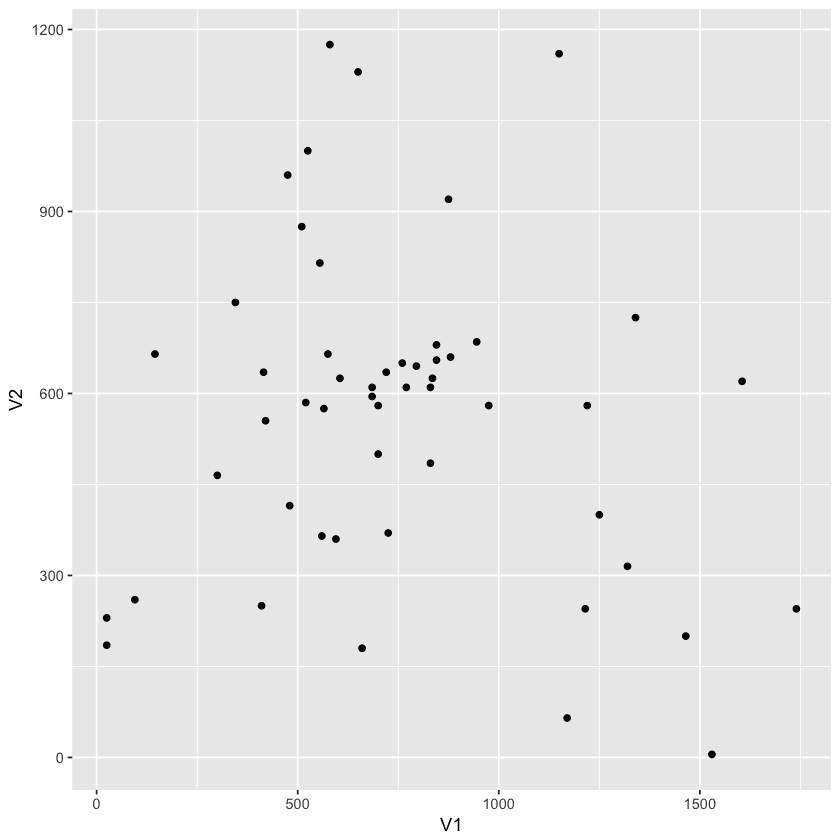

In [19]:
berlin.52 %>%
    as.data.frame() %>%
    ggplot(aes(x = V1, y = V2)) +
        geom_point()

##### st.70

TODO(@garciparedes): Do Example.

In [20]:
st.70 <- 
    "st70.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()

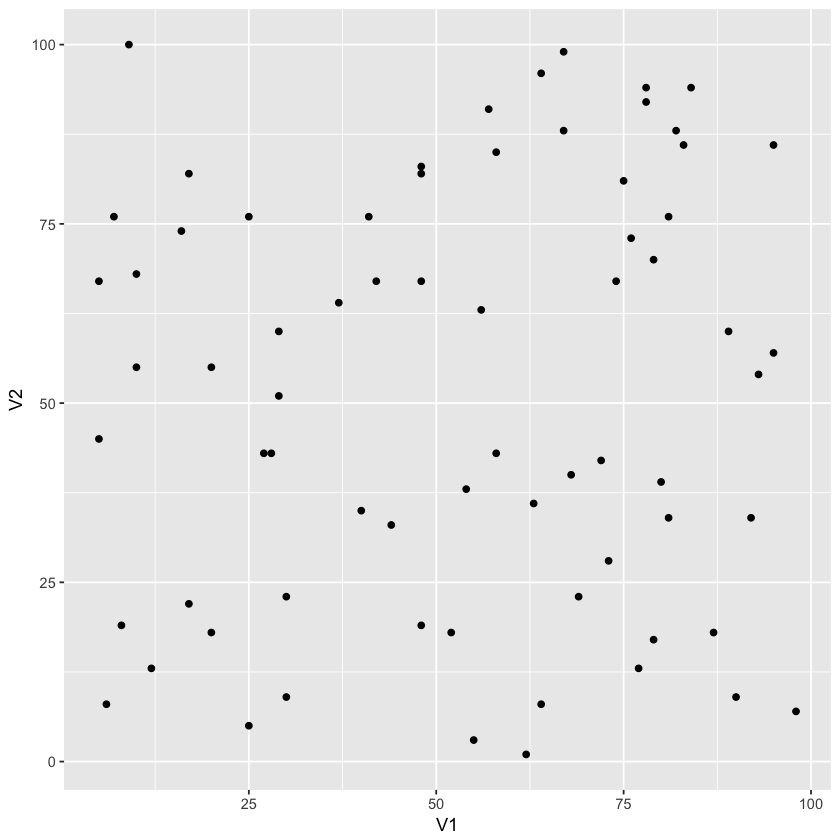

In [21]:
st.70 %>%
    as.data.frame() %>%
    ggplot(aes(x = V1, y = V2)) +
        geom_point()

##### a.280

TODO(@garciparedes): Do Example.

##### gr15.{1,...,5}

TODO(@garciparedes): Do Example.

### Árbol Recubridor Mínimo Capacitado

#### Descripción

TODO

#### Modelo

TODO

#### Ejemplos

TODO

##### gr15.{1,...,5}

TODO(@garciparedes): Do Example.

### Problema de Steiner

#### Descripción

TODO

#### Modelo

TODO

#### Ejemplos

TODO

##### grafo.11.nodos

TODO(@garciparedes): Do Example.

##### gr15.{1,...,5}

TODO(@garciparedes): Do Example.

## Conclusiones

TODO

## Referencias

  * [TRC13] Team, R.C., 2013. R: A language and environment for statistical computing.
  * [GP18] Sergio García Prado. Programación Entera: Heurísticas, 2018. [github.com/garciparedes/integer-programming-heuristics](https://github.com/garciparedes/integer-programming-heuristics).
  * [SA18] Jesús Sáez Aguado. Programación Entera, 2017/18. Facultad de Ciencias: Departamento de Estadística e Investigación Operativa.
  * [THBSST17] Theussl, S., Hornik, K., Buchta, C., Schwendinger, F., Schuchardt, H. and Theussl, M.S., 2017. Package ‘Rglpk’.
  